In [ ]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from scipy.special import iv, kv , gammainc, gamma
from scipy.integrate import quad
import emcee
import multiprocessing, time
import corner

data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])
xl=data['x']
yl=data['y']
el=data['error']
# plt.errorbar(xl, yl, el, fmt='.b', ecolor='red',elinewidth=0.8, capsize=1.5, capthick=0.7)
# plt.xlabel('R [kpc]')
# plt.ylabel('$v_r$ [km/s]')
# plt.title('Milky Way')
xl= np.array(xl)
yl = np.array(yl)
el = np.array(el)
# plt.xscale('log')                   # important line
# plt.grid()
# plt.show()

/tmp/ipykernel_772/2314866297.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])


In [ ]:

import pandas as pd, matplotlib.pyplot as plt, numpy as np
from scipy.special import iv, kv , gammainc, gamma
from scipy.integrate import quad
import emcee
import multiprocessing, time
import corner

data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])
xl=data['x']
yl=data['y']
el=data['error']
xl= np.array(xl)
yl = np.array(yl)
el = np.array(el)

In [ ]:
# ------ MILKY WAY ------
# v_tot^2= v_b^2 + v_d^2 + v_h^2
#  v_h^2= G M_h/r
# DISK (common for all)
G= 4.302e-6
#print(G)

#fv_d= lambda r,a_d, sig_d: np.pi*G* sig_d* (r**2/a_d) *(iv(0,r/(2*a_d))*kv(0,r/(2*a_d)) - iv(1,r/(2*a_d))*kv(1,r/(2*a_d)))
def vd(r,a_d, sig_d):
    if r <= 0:
        return 0.0
    v2= np.pi*G* sig_d* (r**2/a_d) *(iv(0,r/(2*a_d))*kv(0,r/(2*a_d)) - iv(1,r/(2*a_d))*kv(1,r/(2*a_d)))
    if v2>0:
        return np.sqrt(v2)
    return 0.0

In [ ]:
#  BULGE (common for all 3)

k=7.6695
G= 4.302e-6
def sigbr_x(x, sig_b, a_b):
    return sig_b * np.exp(-k * ((x / a_b)**0.25 - 1))

def dsigbr_x_dx(x, sig_b, a_b):
    prefactor = -(k / 4) * (1 / a_b)**0.25 * x**(-0.75)
    return prefactor * sigbr_x(x, sig_b, a_b)

def rhob_r(r, sig_b, a_b):
    def integrand(u):
        x = r * np.cosh(u)
        return dsigbr_x_dx(x, sig_b, a_b)
    integral, _ = quad(integrand, 1e-2, 20)
    return -integral / np.pi
def v_bulge(r, sig_b, a_b):
    def integrand_vb2_r(r_):
        return rhob_r(r_, sig_b, a_b) * r_**2
    integral, _ = quad(integrand_vb2_r, 1e-2, r)
    vb2 = (4 * np.pi * G / r) * integral
    if not np.isfinite(vb2) or vb2 <= 0:
        return np.nan
    return np.sqrt(vb2)

In [6]:
# HALO
# fv_h_nfw= lambda r, rho, h: G*4*np.pi*(rho*h*h*h/r)* [np.log(1+(r/h))- ((r/h)/(1+ (r/h)))]
#fv_h_nfw= lambda r, rho ,h : (G/r)*(4*np.pi*rho*h**3)* (np.log(1+(r/h))- ((r/h)/(1+ (r/h))))
#fv_h_hrn= lambda r, rho, h:  G*2*np.pi*rho*h*r/(1+ (r/h))**2
# fv_h_ens= lambda r, rho, h: G*4*np.pi*rho*0.041*(h**3/r)*[ gammainc( 3*0.041, (r/h)**(1/0.041))]
# fv_h_ens= lambda r, rho, h, n : G*4*np.pi*rho*n*(h**3/r)*(gammainc( 3*n, (r/h)**(1/n)))
def vh_nfw(r, rho, h):
    if r <= 0:
        return 0.0
    v2= (G/r)*(4*np.pi*rho*h**3)* (np.log(1+(r/h))- ((r/h)/(1+ (r/h))))
    if v2>0:
        return np.sqrt(v2)
    return 0.0

rs = np.linspace(0.01, 100, 1000)

In [ ]:
def vh_hern(r, rho, h):
    if r <= 0:
        return 0.0
    v2= G*2*np.pi*rho*h*r/(1+ (r/h))**2
    if v2>= 0:
        return np.sqrt(v2)
    return 0.0

In [8]:
def vh_ein(r, rho_0, h, n):
    mass= 4* np.pi* rho_0* n* h**3* gamma(3*n) * gammainc(3*n, (r/h)**(1/n))
    v2= G*mass/r
    if v2>=0:
        return np.sqrt(v2)
    return 0.0

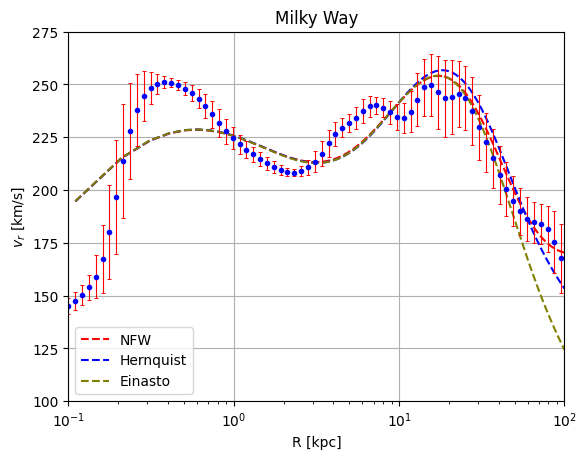

In [9]:
vtotal_nfw= np.sqrt ([ v_bulge(r , 595000000,1.764)**2 + vd(r ,8.817, 566000000)**2 + vh_nfw(r , 7120, 889)**2 for r in rs ]) 
vtotal_hern= np.sqrt ([ v_bulge(r , 592000000,1.775)**2 + vd(r ,9.237, 552000000)**2 + vh_hern(r , 63090, 142.324)**2 for r in rs ]) 
vtotal_ein= np.sqrt ([ v_bulge(r , 593000000,1.775)**2 + vd(r , 9.130, 578000000)**2 + vh_ein(r , 248660, 8.745, 0.041)**2 for r in rs ]) 

plt.plot(rs, vtotal_nfw, color='red',linestyle='--',label ="NFW")
plt.plot(rs, vtotal_hern, color='blue',linestyle='--',label ="Hernquist")
plt.plot(rs, vtotal_ein, color='olive',linestyle='--',label ="Einasto")
plt.errorbar(xl, yl, el, fmt='.b', ecolor='red',elinewidth=0.8, capsize=1.5, capthick=0.7)
plt.xlabel('R [kpc]')
plt.ylabel('$v_r$ [km/s]')
plt.title('Milky Way')
plt.xscale("log")
plt.xlim(0.1,100)
plt.yticks(range(100, 276, 25))
plt.legend()
plt.grid()
plt.show()

In [ ]:
def ln_likeli_nfw(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h):
    vbulge = np.array([v_bulge(x, sig_b, a_b) for x in xl])
    vdisk  = np.array([vd(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([vh_nfw(x, rho, h) for x in xl])
    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

In [11]:
def ln_prior_nfw(theta ):
      a_b, sig_b, a_d, sig_d, rho, h= theta
      if not (1.6 < a_b < 1.9):
          return -np.inf
      if not (0.54 < sig_b < 0.66):
          return -np.inf
      if not ( 8 < a_d < 9.5 ):
          return -np.inf
      if not (0.52 < sig_d < 0.60):
          return -np.inf
      if not (0 < rho < 2):
          return -np.inf
      if not ( 0< h < 2):
         return -np.inf
      return 0.0

In [14]:
theta = [1.8, 0.609, 8.563, 0.533, 1.258, 0.549]
print("ln_prior_nfw =", ln_prior_nfw(theta))

ln_prior_nfw = 0.0


In [12]:
def ln_post_nfw(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h = theta
    lp = ln_prior_nfw(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_nfw(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


In [13]:
import time
init_guess = [1.8, 0.609, 8.563, 0.553, 1.258, 0.549]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
for _ in range(10):
    theta = init_guess + np.random.normal(0, [0.015, 0.006, 0.075, 0.04, 0.1, 0.1])
    t0 = time.time()
    val = ln_post_nfw(theta, xl, yl, el)
    print(f"ln_post_nfw = {val:.2f}, Time = {time.time() - t0:.4f} sec")

ln_post_nfw = -inf, Time = 0.0001 sec
ln_post_nfw = -inf, Time = 0.0000 sec
ln_post_nfw = -87193.35, Time = 10.5890 sec
ln_post_nfw = -87193.22, Time = 8.5509 sec
ln_post_nfw = -87193.29, Time = 8.4690 sec
ln_post_nfw = -87193.53, Time = 8.5602 sec
ln_post_nfw = -inf, Time = 0.0000 sec
ln_post_nfw = -87193.49, Time = 9.5354 sec
ln_post_nfw = -87193.42, Time = 8.4096 sec
ln_post_nfw = -87193.35, Time = 8.5416 sec


In [ ]:
# ---- MCMC SETUP ----
ndim = 6           # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 5000      # Steps each walker takes
burnin = 1000      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.8, 0.609, 8.563, 0.553, 1.258, 0.549]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [0.015, 0.006, 0.075, 0.04, 0.1, 0.1], (nwalkers, ndim))

In [ ]:
#   TRY NOT TO USE THIS, IN ORDER TO USE FULL CPU CAPACITY ---- RUN THE MCMC ----

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post_nfw, args=( xl, yl, el))   #sampler object
# Actually run the chains
print(pos.shape)
sampler.run_mcmc(pos, nsteps, progress=True)
print("Sampler finished. Samples shape:", sampler.get_chain().shape) # gives you a 3D array: nsteps, nwalkers, ndim

In [17]:
import multiprocessing
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_nfw,
            args=(xl, yl, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)
'''
a flattened 2D version:
(nsteps × nwalkers - burnin × nwalkers, ndim)
All post-burn-in samples from all walkers are flattened into one big 2D array
Each row = one accepted parameter set (theta)
Shape = (N_samples, 6) 
'''


100%|██████████| 5000/5000 [66:36:26<00:00, 47.96s/it]    

Shape of samples: (200000, 6)


'\na flattened 2D version:\n(nsteps × nwalkers - burnin × nwalkers, ndim)\nAll post-burn-in samples from all walkers are flattened into one big 2D array\nEach row = one accepted parameter set (theta)\nShape = (N_samples, 6) in your case (since you have 6 parameters)\n'

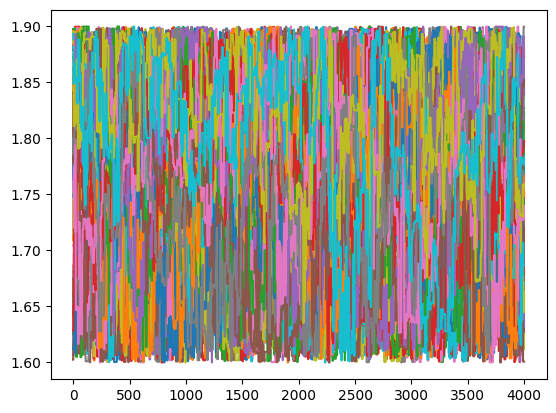

In [18]:
for i in range(0,nwalkers):
  a=sampler.chain[i,burnin:,0]
  l=len(a)
  n= list(range(l))
  plt.plot(n,a)
plt.show()

In [23]:
tau = sampler.get_autocorr_time()


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [185.81482293 200.54500489 182.95196344 185.94783349 194.08929324
 207.24286509]

In [19]:
print(" Milky Way: NFW")
ab_samp = flat_samples[:, 0]  # All sampled values of a_b
sb_samp = flat_samples[:, 1]  # All sampled values of sigma_b
ad_samp = flat_samples[:, 2]  # All sampled values of a_d
sd_samp = flat_samples[:, 3]  # All sampled values of sigma_d
rho_samp= flat_samples[:, 4]  # rho_0
h_samp= flat_samples[:, 5]
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")

 Milky Way: NFW
a_b = 1.766 ± 0.085
sigma_b = 0.603 ± 0.035
a_d = 8.769 ± 0.428
sigma_d = 0.562 ± 0.023
rho_0 = 1.248 ± 0.545
h = 1.335 ± 0.547


In [22]:
# For checking
print(flat_samples.shape)
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
for _ in range(10):
    scale = np.array([0.015, 0.006, 0.075, 0.04, 0.1, 0.1])
    test = init_guess + np.random.normal(0, scale)
    print(test, ln_post_nfw(test, xl, yl, el))


(200000, 6)
Mean acceptance fraction: 0.250588
[1.78756507 0.60563891 8.61904702 0.57741481 1.25590984 0.56073274] -87193.39808478129
[1.81916497 0.60545057 8.6040323  0.54491229 1.23623188 0.65887769] -87193.30640260312
[1.81238125 0.61388106 8.66091091 0.55384015 1.3261953  0.51797332] -87193.37118678191
[1.8048625  0.60821914 8.5702747  0.57680628 1.17617793 0.75823873] -87193.2227579729
[1.78490974 0.60171487 8.64985832 0.58466651 1.32041198 0.61183455] -87193.35869011705
[1.7998163  0.60361647 8.56868534 0.52591353 1.35551197 0.53429426] -87193.43449213539
[1.78761754 0.60707168 8.59396986 0.53045102 1.17577796 0.57336872] -87193.43590716948
[1.8036745  0.60595834 8.52767213 0.562282   1.11319157 0.40825362] -87193.4962695066
[1.78922334 0.60771932 8.58631807 0.61201425 1.34376596 0.53300615] -inf
[1.79971476 0.60298482 8.56161151 0.54145365 1.29027186 0.46627691] -87193.4802130038


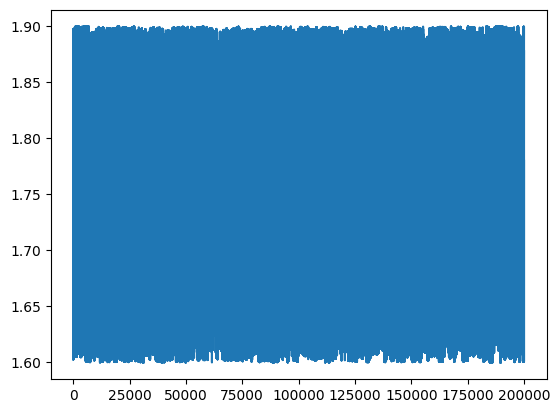

In [21]:
plt.plot(ab_samp)

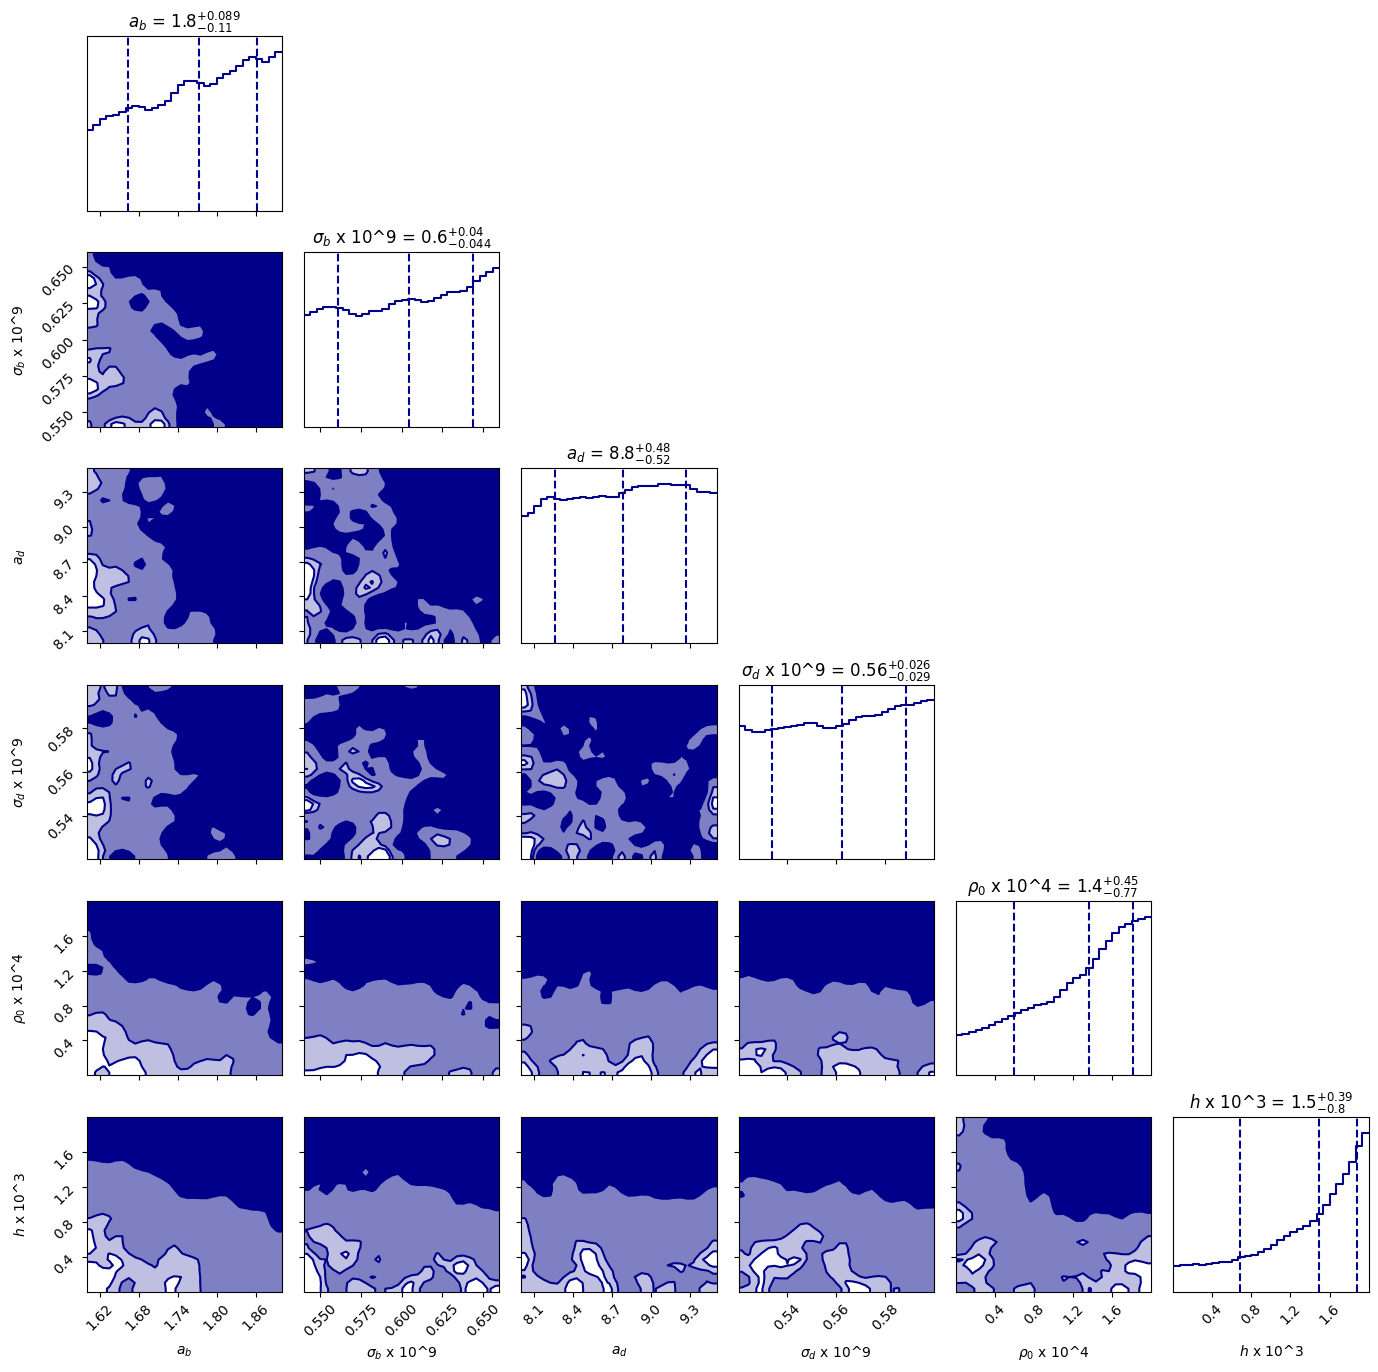

In [ ]:
import corner

corner.corner(
    flat_samples,                                                                             
    labels=["$a_b$", "$\\sigma_b$ x 10^9", "$a_d$", "$\\sigma_d$ x 10^9", "$\\rho_0$ x 10^4", "$h$ x 10^3"],
    bins=30,
    color="darkblue",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=1.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True
)
plt.tight_layout()
plt.show()

HERNQUIST 

In [ ]:
def ln_likeli_hern(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h):
    vbulge = np.array([v_bulge(x, sig_b, a_b) for x in xl])
    vdisk  = np.array([vd(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([vh_hern(x, rho, h) for x in xl])

    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

In [ ]:
def ln_prior_hern(theta):                                        # Uniform prior
      a_b, sig_b, a_d, sig_d, rho, h = theta
      if not (1.6 < a_b < 1.9):
          return -np.inf
      if not (0.55 < sig_b < 0.625):
          return -np.inf
      if not ( 8.5 < a_d < 10 ):
          return -np.inf
      if not (0.52 < sig_d < 0.60):
          return -np.inf
      if not (4 < rho < 8):
          return -np.inf
      if not ( 130< h < 160):
         return -np.inf
      return 0.0

In [ ]:
def ln_post_hern(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h = theta
    lp = ln_prior_hern(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_hern(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
# ---- MCMC SETUP ----
ndim = 6           # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 5000      # Steps each walker takes
burnin = 1000      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.81, 0.605, 9.442, 0.565, 6.8, 126.33 ] # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0,[0.015, 0.004, 0.075, 0.004, 0.2, 1.5] , (nwalkers, ndim))

In [ ]:
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_hern,
            args=(xl, yl, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)

In [ ]:
print(" Milky Way:Hernquist")
ab_samp = flat_samples[:, 0]  # All sampled values of a_b
sb_samp = flat_samples[:, 1]  # All sampled values of sigma_b
ad_samp = flat_samples[:, 2]  # All sampled values of a_d
sd_samp = flat_samples[:, 3]  # All sampled values of sigma_d
rho_samp= flat_samples[:, 4]  # rho_0
h_samp= flat_samples[:, 5]
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")

In [ ]:
for i in range(0,nwalkers):
  a=sampler.chain[i,burnin:,0]
  l=len(a)
  n= list(range(l))
  plt.plot(n,a)
plt.show()

In [ ]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
plt.plot(ab_samp)

In [ ]:
corner.corner(
    flat_samples,                                                                              # samples_scaled, in place of flat samples?
    labels=["$a_b$", "$\\sigma_b$ x 10^9", "$a_d$", "$\\sigma_d$ x 10^9", "$\\rho_0$ x 10^4", "$h$ x 10^3"],
    bins=30,
    color="darkblue",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=1.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True
)
plt.tight_layout()
plt.show()

EINASTO

In [ ]:
def ln_likeli_ein(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h, n):
    vbulge = np.array([v_bulge(x, sig_b, a_b) for x in xl])
    vdisk  = np.array([vd(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([vh_ein(x, rho, h, n) for x in xl])

    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_ein(theta):
      a_b, sig_b, a_d, sig_d, rho, h, n = theta
      if not (1.7 < a_b <1.9):
          return -np.inf
      if not (0.56 < sig_b < 0.64):
          return -np.inf
      if not ( 8.5 < a_d < 10 ):
          return -np.inf
      if not (0.52 < sig_d < 0.64):
          return -np.inf
      if not (10< rho <50):
          return -np.inf
      if not ( 0< h< 30):
         return -np.inf
      if not ( -0.5<n< 0.5):
          return -np.inf
      return 0.0

def ln_post_ein(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h, n = theta
    lp = ln_prior_ein(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_ein(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h, n)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
# ---- MCMC SETUP ----
ndim = 7           # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 5000      # Steps each walker takes
burnin = 1000      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.82, 0.606, 9.43, 0.59, 15.33, 2.822, 0.512 ]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [0.01, 0.004, 0.075, 0.006, 2, 1.5, 0.05 ], (nwalkers, ndim))

if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_ein,
            args=(xl, yl, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)

In [ ]:
print(" Milky Way: Einasto")
ab_samp = flat_samples[:, 0]  # All sampled values of 
sb_samp = flat_samples[:, 1]  # All sampled values of 
ad_samp = flat_samples[:, 2]  # All sampled values of a_d
sd_samp = flat_samples[:, 3]  # All sampled values of sigma_d
rho_samp= flat_samples[:, 4]  # All sampled values of rho_0
h_samp= flat_samples[:, 5]    # All sampled values of h
n_samp= flat_samples[:, 6]    # All sampled values of n
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")
print(f"h = {np.mean(n_samp):.3f} ± {np.std(n_samp):.3f}")

In [ ]:
for i in range(0, nwalkers):
  a=sampler.chain[i,burnin:,0]
  l=len(a)
  n= list(range(l))
  plt.plot(n,a)
plt.show()

In [ ]:
print( "Mean acceptance fraction => ", np.mean(sampler.acceptance_fraction))
plt.plot(ab_samp)

In [ ]:
corner.corner(
    flat_samples,                                                                              # samples_scaled, in place of flat samples?
    labels=["$a_b$", "$\\sigma_b$ x 10^9", "$a_d$", "$\\sigma_d$ x 10^9", "$\\rho_0$ x 10^4", "$h$ x 10^3", "n"],
    bins=30,
    color="darkblue",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=1.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True
)
plt.tight_layout()
plt.show()